# Bank Telemarketing

In recent times, it has become important to determine how to target customers to make deposits in a bank. It is very diffcult to figure this out by manual labour. There are hundreds of thousands of entries made every single day and quite a lot of factors affecting them. So with the help of Python tools and some Machine Learning algorithms, we try to predict if a customer is going to make a deposit in the bank. 


## Dataset information

This dataset was taken from a Portuguese banking institution. The data is related with direct marketing campaigns (phone calls). The final goal of this is to predict if the customer is going to subscribe to term deposit. 

# Input variables:
## Bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
## related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone') 
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
## other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
## social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric) 
- cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

## Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import numpy as np
import pandas as pd

import csv
import random
import math

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection

from sklearn import metrics
from sklearn.metrics import accuracy_score

In [2]:
dataset = pd.read_csv('bank-additional-full.csv')
print(dataset.shape)
dataset.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Exploratory Analysis:

## Categorical Variables:

We first start the exploratory analysis of the categorical variables and see what are the categories and are there any missing values for these categories. Here, we used the seaborn package to create the bar graphs below.

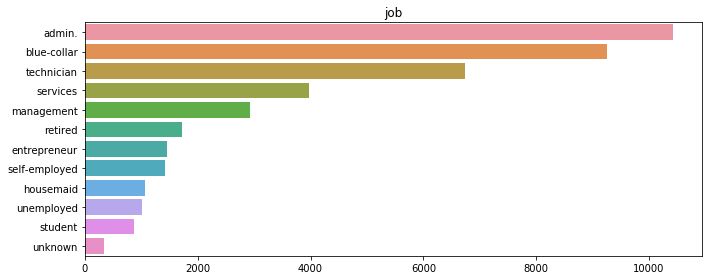

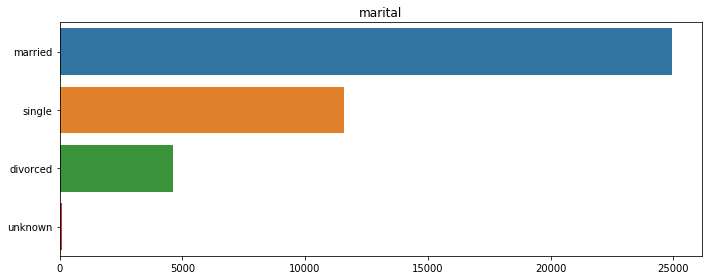

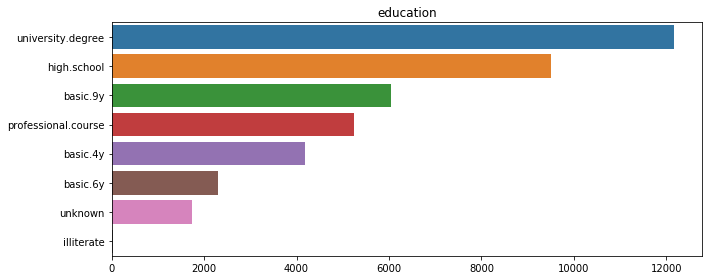

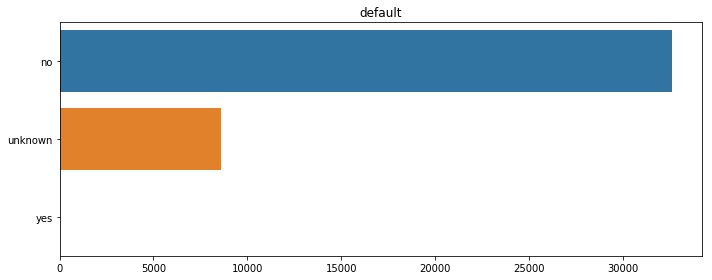

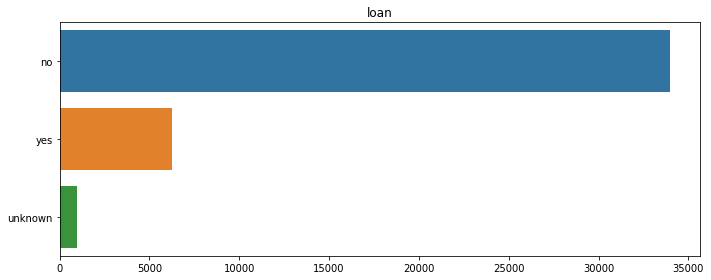

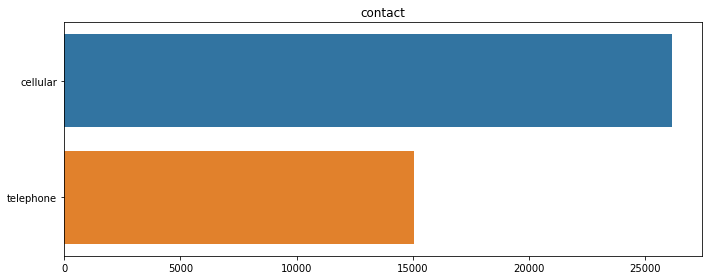

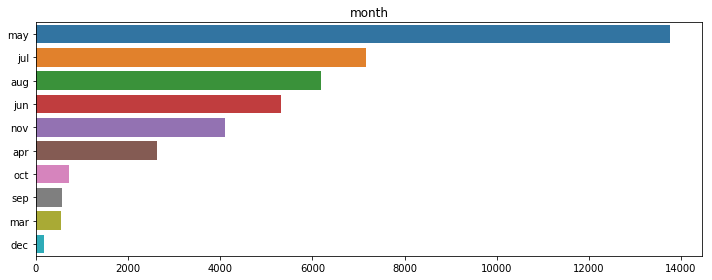

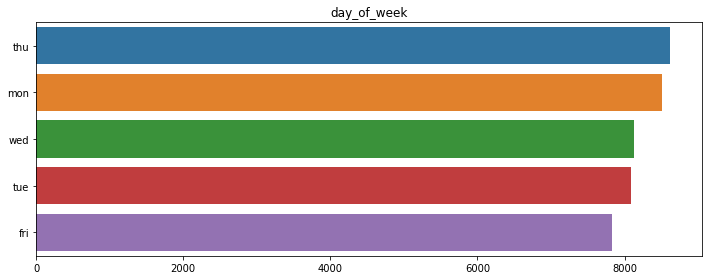

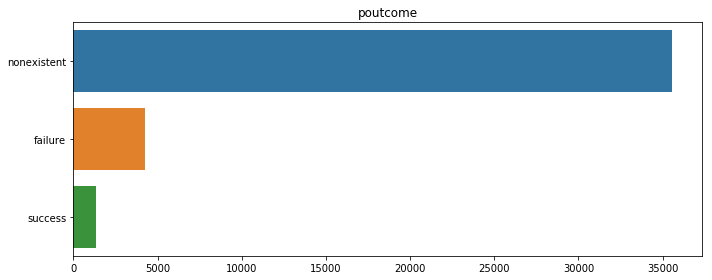

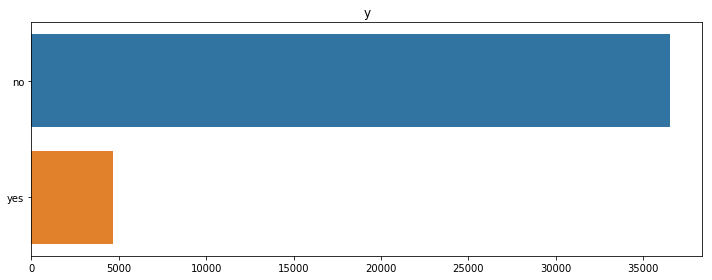

In [3]:
categorcial_variables = ['job', 'marital', 'education', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome','y']
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    sns.barplot(dataset[col].value_counts().values, dataset[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()
plt.show()


## List of normalized relative frequency of the target class per category. 

Normalized distribution of each class per feature and plotted difference between positive and negative frequencies. Positive values imply this category favors clients that will subscribe and negative values categories that favor not buying the product.

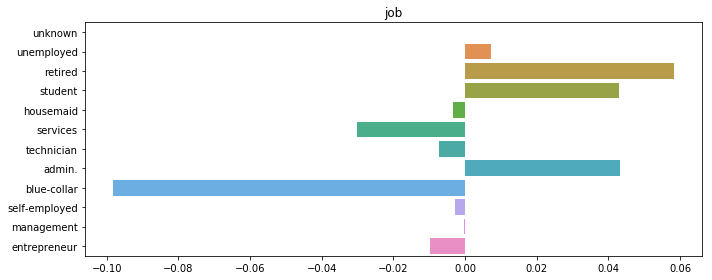

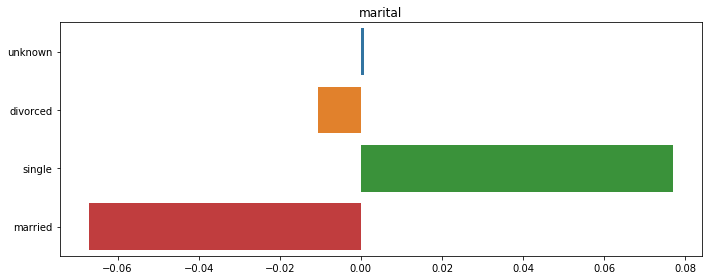

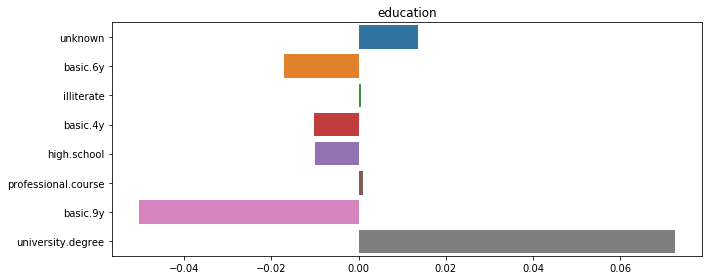

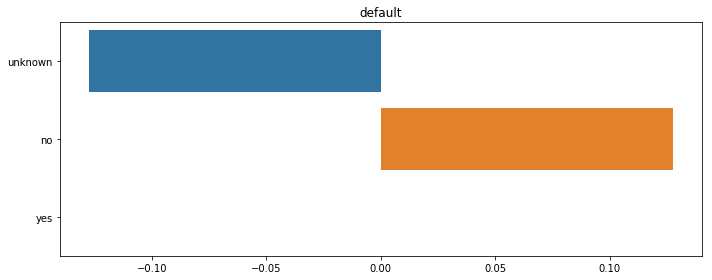

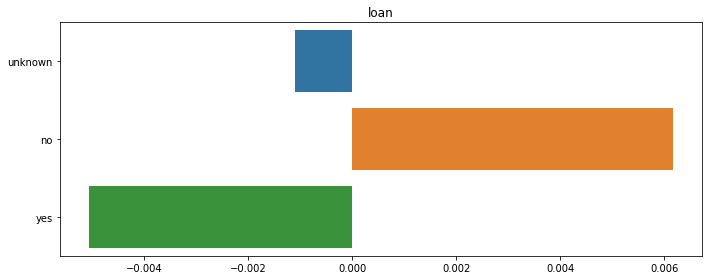

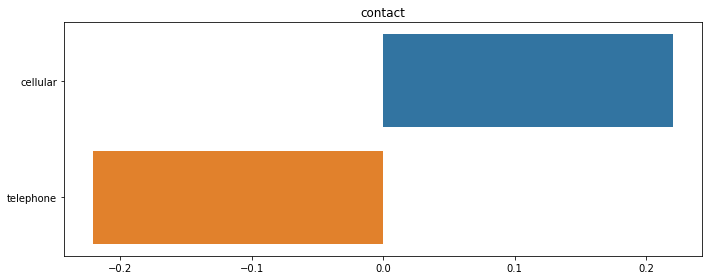

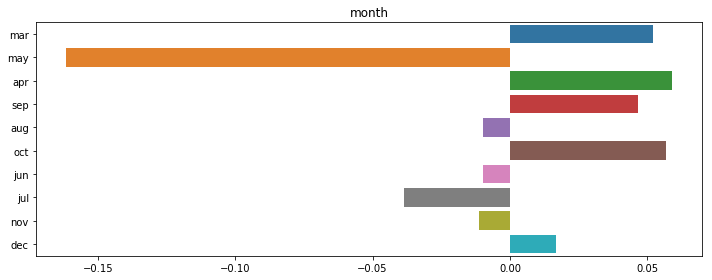

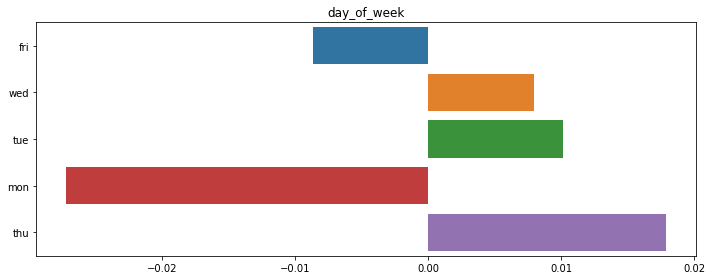

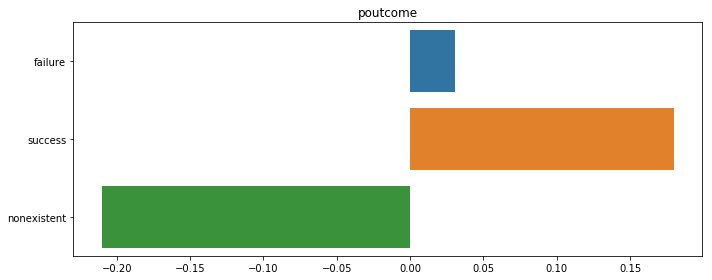

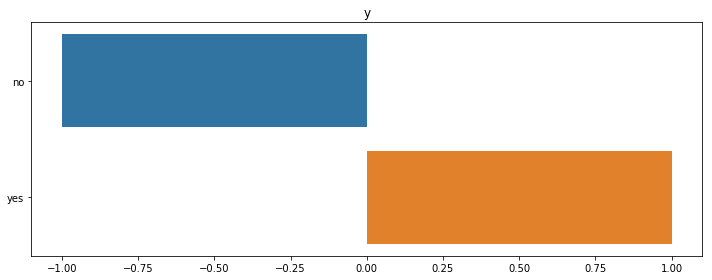

In [4]:
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    #Returns counts of unique values for each outcome for each feature.
    pos_counts = dataset.loc[dataset.y.values == 'yes', col].value_counts() 
    neg_counts = dataset.loc[dataset.y.values == 'no', col].value_counts()
    
    all_counts = list(set(list(pos_counts.index) + list(neg_counts.index)))
    
    #Counts of how often each outcome was recorded.
    freq_pos = (dataset.y.values == 'yes').sum()
    freq_neg = (dataset.y.values == 'no').sum()
    
    pos_counts = pos_counts.to_dict()
    neg_counts = neg_counts.to_dict()
    
    all_index = list(all_counts)
    all_counts = [pos_counts.get(k, 0) /  freq_pos - neg_counts.get(k, 0)  / freq_neg for k in all_counts]

    sns.barplot(all_counts, all_index)
    plt.title(col)
    plt.tight_layout()
    

**Inference/Result**: There are unknown values for many variables in the Data set. There are many ways to handle missing data. One of the ways is to discard the row but that would lead to reduction of data set and hence would not be an accurate model.

Other method is to infer the value of the unknown from other variables. Here we use other independent variables to infer missing values.

Variables with unknown/missing values are: 'education', 'job', 'housing', 'loan', 'default', and 'marital'.

## Imputation:

In [5]:
df = dataset

In [6]:
df['job'][df['age']>60].value_counts()

retired          678
housemaid         54
admin.            47
technician        34
management        30
unknown           21
blue-collar       20
self-employed      9
entrepreneur       8
unemployed         7
services           2
Name: job, dtype: int64

From this we can infer that most of the members with age above 60 are retires hence we can replace unknown job values with 60+ age as retired.

In [7]:
df.loc[(df["age"]>60) & (df["job"]=='unknown'), 'job'] = 'retired'

Now, to infer the missing values in 'job' and 'education', we make use of the cross-tabulation between 'job' and 'education'. Our hypothesis here is that 'job' is influenced by the 'education' of a person. Hence, we can infer 'job' based on the education of the person.

In [8]:
def cross_tab(df,f1,f2):
    jobs=list(df[f1].unique())
    edu=list(df[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=df[df[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx

In [9]:
crossTab = cross_tab(df,'job','education')

In [10]:
crossTab

,basic.4y,high.school,basic.6y,basic.9y,professional.course,unknown,university.degree,illiterate
admin.,77,3329,151,499,363,249,5753,1.0
blue-collar,2318,878,1426,3623,453,454,94,8.0
entrepreneur,137,234,71,210,135,57,610,2.0
housemaid,474,174,77,94,59,42,139,1.0
management,100,298,85,166,89,123,2063,0.0
retired,601,276,75,145,243,112,286,3.0
self-employed,93,118,25,220,168,29,765,3.0
services,132,2682,226,388,218,150,173,0.0
student,26,357,13,99,43,167,170,0.0
technician,58,873,87,384,3320,212,1809,0.0


In [11]:
max_values = crossTab.idxmax(axis=1) #this stores key-value pair of job-education to predict education
max_values1 = crossTab.idxmax(axis=0)#this stores key-value pair of educaiton-job to predict job 

In [12]:
max_values

admin.             university.degree
blue-collar                 basic.9y
entrepreneur       university.degree
housemaid                   basic.4y
management         university.degree
retired                     basic.4y
self-employed      university.degree
services                 high.school
student                  high.school
technician       professional.course
unemployed         university.degree
unknown                      unknown
dtype: object

In [13]:
max_values1

basic.4y               blue-collar
high.school                 admin.
basic.6y               blue-collar
basic.9y               blue-collar
professional.course     technician
unknown                blue-collar
university.degree           admin.
illiterate             blue-collar
dtype: object

In [14]:
max_values1.pop('unknown')
max_values.pop('unknown')

'unknown'

There maybe be some rows whose education and job both is unknown so we randomly choose a job and then predict education using this value. Since the unknown count in education is significantly high we are predicting job rather than education.

In [15]:
df.loc[(df['education']=='unknown') & (df['job']=='unknown'),'job'] = random.choice(max_values1)

In [16]:
# Replaces unknown values of education based on job
for i in max_values.keys():
    df.loc[(df['education'] =='unknown') & (df['job'] == i),'education'] = max_values[i]

In [17]:
# Replaces unknown values of job based on education
for i in max_values1.keys():
    df.loc[(df['job'] =='unknown') & (df['education'] == i),'job'] = max_values1[i]

In [18]:
dummiess = pd.get_dummies(df['pdays'])

### Missing pdays values

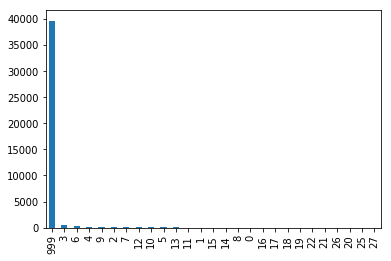

In [19]:
# s = df.groupby("keys").ids.agg(lambda x:len(x.unique()))
pd.value_counts(df['pdays']).plot(kind="bar")

From the plot we can see that majority of the values are '999' i.e., the cutomer has never contacted before. So we are dropping this column as this may not be as useful.

In [20]:
df = df.drop('pdays', axis=1);

In [21]:
mapping = {'unknown': np.nan, 'nonexistent': np.nan, 'yes': 1, 'no': 0, 'success': 1, 'failure': 0}
df = df.replace(mapping)
# df['pdays'] = df['pdays'].replace(999 , 0)

In [22]:
categorical_variables = ['marital', 'contact', 'month', 'day_of_week']

In [23]:
df[['default', 'housing', 'loan', 'poutcome', 'y']] = df[['default', 'housing', 'loan', 'poutcome', 'y']].apply(pd.to_numeric)

In [24]:
g = df.columns.to_series().groupby(df.dtypes).groups
g

{dtype('int64'): Index(['age', 'duration', 'campaign', 'previous', 'y'], dtype='object'),
 dtype('float64'): Index(['default', 'housing', 'loan', 'poutcome', 'emp.var.rate',
        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
       dtype='object'),
 dtype('O'): Index(['job', 'marital', 'education', 'contact', 'month', 'day_of_week'], dtype='object')}

### Replacing NaN values

Here we are replacing all missing categorical values with random values and as 'job' and 'education' were replaced earlier there are excluded from the categorical values. And all other numerical values are replaced by their mean values.

In [25]:
for i in df:
    if i in categorical_variables: 
        uniques = list(df[i].unique())
        if np.nan in uniques:
            uniques.remove(np.nan)
        print(uniques)
        k = 0
        for j in df[i]:
            if j is np.nan:
                df[i][k] = random.choice(uniques)
            k += 1
    elif i == 'job' or i == 'education':
        continue
    else:
        print(i)
        for j in range(len(df[i])):
            if math.isnan(df[i][j]):
                df[i].fillna(df[i].mean(),inplace=True)

age
['married', 'single', 'divorced']


C:\Users\Onkar\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


default
housing
loan
['telephone', 'cellular']
['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr', 'sep']
['mon', 'tue', 'wed', 'thu', 'fri']
duration
campaign
previous
poutcome
emp.var.rate
cons.price.idx
cons.conf.idx
euribor3m
nr.employed
y


In [26]:
len(df) - df.count() #Here count() tells us the number of non-NaN values, and this is subtracted from the total number of values (given by len(df)).

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

## Label Encoding

Here all the categorical variables are selected and encoded using label encoder

In [27]:
from sklearn.preprocessing import LabelEncoder
categorical_values  = df[['job', 'marital', 'education', 'contact', 'month', 'day_of_week']]

In [28]:
val = LabelEncoder()
for i in categorical_values.keys():
    categorical_values[i] = val.fit_transform(categorical_values[i].astype('str'))

C:\Users\Onkar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
for i in categorical_values:
    df = df.drop(i,axis =1)

In [30]:
y = df.iloc[:,13]
df = df.drop('y',axis = 1)

In [31]:
df = pd.concat([df, categorical_values],axis = 1)

In [32]:
df.head()

,age,default,housing,loan,duration,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,contact,month,day_of_week
0,56,0.000000,0.0,0.0,261,1,0,0.244089,1.1,93.994,-36.4,4.857,5191.0,3,1,0,1,6,1
1,57,0.000092,0.0,0.0,149,1,0,0.244089,1.1,93.994,-36.4,4.857,5191.0,7,1,3,1,6,1
2,37,0.000000,1.0,0.0,226,1,0,0.244089,1.1,93.994,-36.4,4.857,5191.0,7,1,3,1,6,1
3,40,0.000000,0.0,0.0,151,1,0,0.244089,1.1,93.994,-36.4,4.857,5191.0,0,1,1,1,6,1
4,56,0.000000,0.0,1.0,307,1,0,0.244089,1.1,93.994,-36.4,4.857,5191.0,7,1,3,1,6,1


## Normalization

Here the normalization is done by using Min-Max scalar. Reason for using normalization is to reduce the disparity between the value.

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
             'euribor3m', 'nr.employed']#add pdays
df[num] = scaler.fit_transform(df[num])

In [34]:
X = df.iloc[:,0:19]

In [35]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, shuffle = True) #80/20 split

# Training and testing

## 1. Logistic Regression

Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary).  Like all regression analyses, the logistic regression is a predictive analysis.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

In [36]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', max_iter = 1000)
model.fit(x_train, y_train)
prediction = model.predict(x_test)

In [37]:
accuracy_score(y_test, prediction)

0.9094440398154892

## 2. Support Vector Machine (SVM)

In [38]:
from sklearn.svm import SVC

In [39]:
clf = SVC()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
accuracy_score(y_test, pred)

0.8964554503520272

## 3. Decision Tree Classifier

In [40]:
from sklearn import tree

In [41]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [42]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [43]:
predi = clf.predict(x_test)

accuracy_score(y_test, predi)

0.8832240835154164

## 4. Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [45]:
X, y = make_classification(n_samples=41188, n_features=20, shuffle=True)
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
clf.fit(x_train, y_train)

print(clf.feature_importances_)

print(clf.predict(x_test))
accuracy_score(y_test, predi)

[1.43033564e-02 6.66346571e-04 0.00000000e+00 0.00000000e+00
 1.79291363e-01 1.79058283e-03 3.16399201e-02 1.19692751e-01
 7.72170895e-02 2.83160110e-02 7.44464242e-02 2.15687269e-01
 2.29304297e-01 0.00000000e+00 5.59480470e-05 1.41929695e-04
 1.20802212e-02 1.51552315e-02 2.11258861e-04]
[0 0 0 ... 0 0 0]


0.8832240835154164

In [46]:
y_train = pd.get_dummies(y_train)

## Neural Network

In [47]:
import keras
from keras.models import Sequential
from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier

C:\Users\Onkar\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [48]:
model = Sequential()
model.add(Dense(30, activation='tanh', input_dim=19))
model.add(Dense(20, activation='tanh'))
model.add(Dense(12, activation='tanh'))
model.add(Dense(6, activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adagrad',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
history = model.fit(x=x_train,y=y_train,epochs=100,validation_split=0.25,verbose=0)

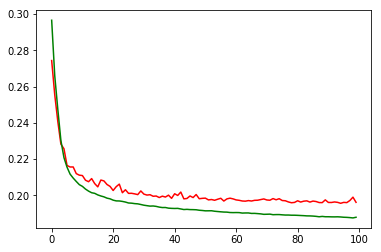

In [50]:
plt.plot(history.epoch, history.history['val_loss'], 'r',
        history.epoch, history.history['loss'], 'g')

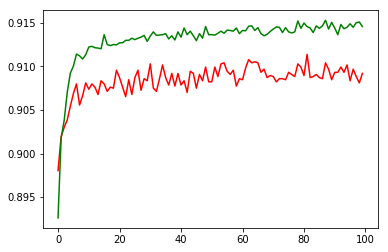

In [51]:
plt.plot(history.epoch, history.history['val_acc'], 'r',
        history.epoch, history.history['acc'], 'g')

In [52]:
y_test = pd.get_dummies(y_test)

In [53]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

8238/8238 [==============================] - 0s 12us/step
Test accuracy: 0.9112648700851641
